In [22]:
import pandas as pd

df = pd.read_csv("data.csv", header=None, names=[
    "m", "n", "k", "test_case_name", "name", "avg", "0.5", "0.8", "0.9", "0.95", "0.99", "0.999"
])

df["m,n,k"] = df["m"].astype(str) + "," + df["n"].astype(str) + "," + df["k"].astype(str)
df.drop(columns=["m", "n", "k"], inplace=True)

cases = {"SM80_Device_Gemm_s4t_s4n_s4t_tensor_op_s32": "int4_normal",
         "SM80_Device_Gemm_s4n_s4t_s4n_tensor_op_s32": "int4_interleaved",
         "SM80_Device_Gemm_s8t_s8n_s8t_tensor_op_s32": "int8_normal",
         "SM80_Device_Gemm_s8n_s8t_s8n_tensor_op_s32": "int8_interleaved",
         }

# df.groupby(["m,n,k", "test_case_name"]).mean().unstack().to_csv("data.csv")
min_avg_rows = df.loc[df.groupby(['m,n,k', 'test_case_name'])['avg'].idxmin()]
min_avg_rows = min_avg_rows[min_avg_rows["test_case_name"].isin(cases.keys())]
min_avg_rows["test_case_name"] = min_avg_rows["test_case_name"].map(cases)
min_avg_rows.sort_values(by=["m,n,k", "test_case_name"], inplace=True)
for index, row in min_avg_rows.iterrows():
    m,n,k = row["m,n,k"].split(",")
    m,n,k = int(m), int(n), int(k)
    min_avg_rows.at[index, "tops"] = m * n * k / float(row["0.99"]) / 1e12
min_avg_rows

,test_case_name,name,avg,0.5,0.8,0.9,0.95,0.99,0.999,"m,n,k",tops
5,int4_interleaved,64x128x128_32x64x128,0.012689,0.013986,0.014377,0.014447,0.014597,0.015739,0.023584,"3072,1536,384",0.115124
2,int4_normal,L0_128x256x256_64x64x256,0.023965,0.026258,0.026940,0.027121,0.027231,0.027872,0.035265,"3072,1536,384",0.065009
11,int8_interleaved,64x64x64_32x32x64,0.022242,0.024526,0.024836,0.025217,0.025427,0.026490,0.033312,"3072,1536,384",0.068401
8,int8_normal,L0_128x256x128_64x64x128,0.025515,0.028143,0.028363,0.028513,0.028804,0.029265,0.038071,"3072,1536,384",0.061915
4,int4_interleaved,64x128x128_32x64x128,0.011116,0.011962,0.012684,0.012905,0.012984,0.013826,0.021420,"3072,384,1536",0.131053
1,int4_normal,L0_128x256x256_64x64x256,0.018859,0.020989,0.021149,0.021229,0.021320,0.021791,0.030306,"3072,384,1536",0.083151
10,int8_interleaved,64x64x64_32x32x64,0.017641,0.019497,0.019687,0.020128,0.020298,0.020849,0.028623,"3072,384,1536",0.086908
7,int8_normal,L0_128x256x128_64x64x128,0.026083,0.028824,0.029084,0.029305,0.029425,0.030026,0.039073,"3072,384,1536",0.060346
3,int4_interleaved,64x128x128_32x64x128,0.007004,0.007674,0.007955,0.008196,0.008426,0.009006,0.017934,"3072,384,384",0.050298
0,int4_normal,L0_128x256x256_64x64x256,0.012847,0.014177,0.014427,0.014577,0.014968,0.015449,0.022512,"3072,384,384",0.029321


In [27]:
# 对不同的 m,n,k 组合，求 int4_normal/int8_normal 的 tops 和 int4_interleaved/int8_interleaved 的 tops 的比值

normal_speedup = min_avg_rows.groupby(["m,n,k"]).apply(lambda x: x[x["test_case_name"] == "int4_normal"]["tops"].values[0] / x[x["test_case_name"] == "int8_normal"]["tops"].values[0])
interleaved_speedup = min_avg_rows.groupby(["m,n,k"]).apply(lambda x: x[x["test_case_name"] == "int4_interleaved"]["tops"].values[0] / x[x["test_case_name"] == "int8_interleaved"]["tops"].values[0])

normal_speedup, interleaved_speedup

/tmp/ipykernel_112697/533437835.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  normal_speedup = min_avg_rows.groupby(["m,n,k"]).apply(lambda x: x[x["test_case_name"] == "int4_normal"]["tops"].values[0] / x[x["test_case_name"] == "int8_normal"]["tops"].values[0])
/tmp/ipykernel_112697/533437835.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interleaved_speedup = min_avg_rows.groupby(["m,n,k"]).appl

(m,n,k
 3072,1536,384    1.049978
 3072,384,1536    1.377908
 3072,384,384     1.049259
 dtype: float64,
 m,n,k
 3072,1536,384    1.683080
 3072,384,1536    1.507956
 3072,384,384     1.155785
 dtype: float64)

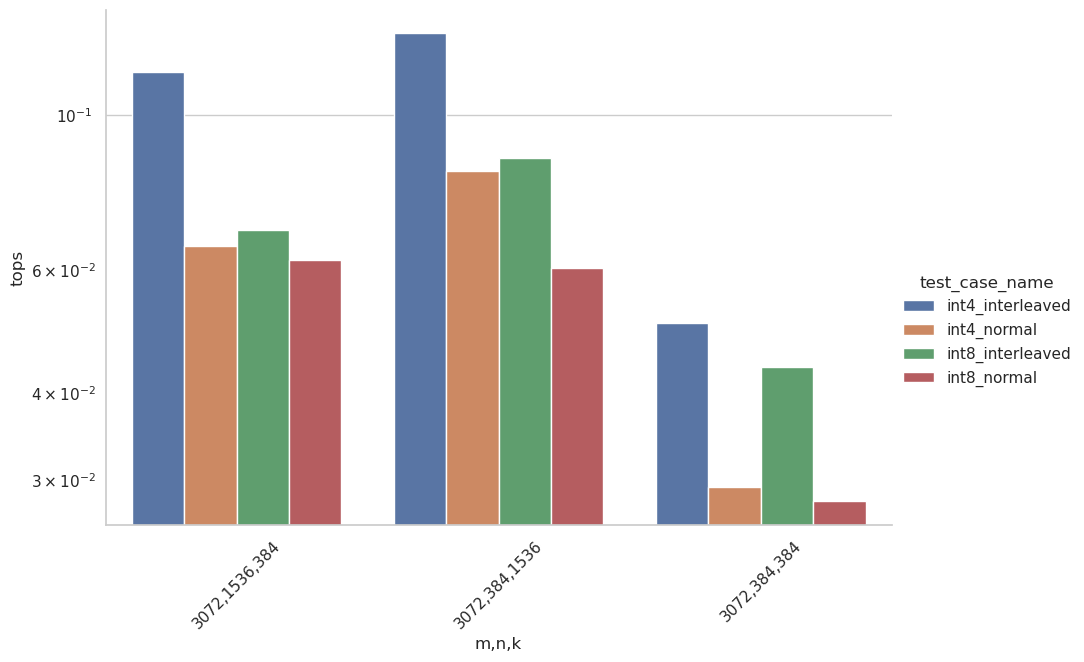

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
# 画柱形图，m,n,k 相同的为一组

sns.set_theme(style="whitegrid")
g = sns.catplot(data=min_avg_rows, x="m,n,k", y="tops", hue="test_case_name", kind="bar", height=6, aspect=1.5)
g.set_axis_labels("m,n,k", "tops")
g.set_xticklabels(rotation=45)
g.set(yscale="log")
plt.show()

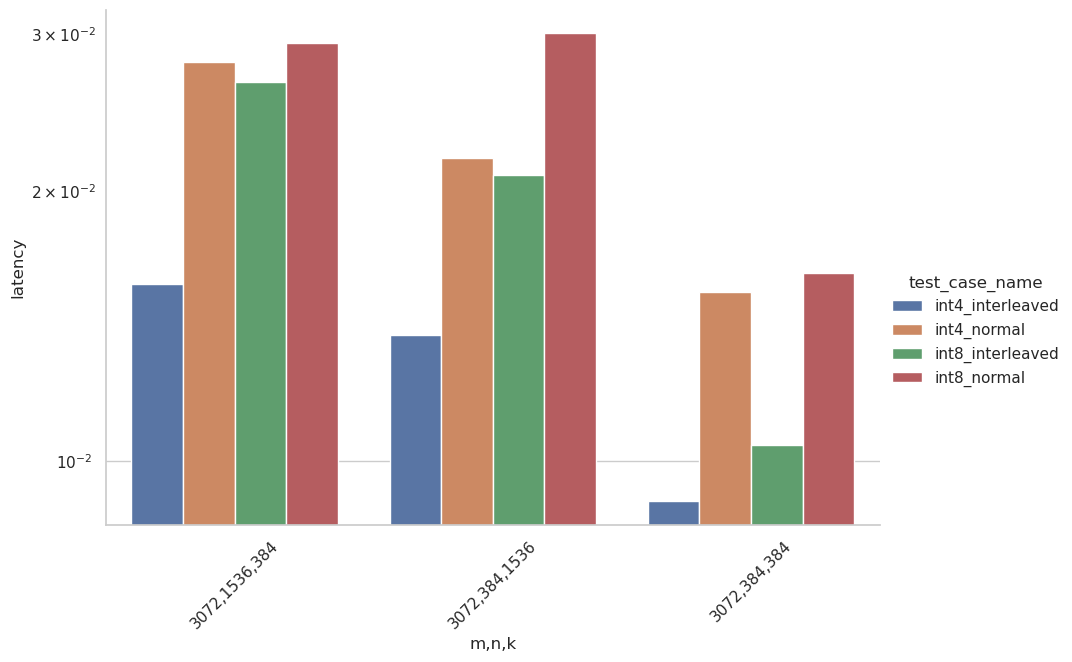

In [24]:
# 0.99, mnk
sns.set_theme(style="whitegrid")
g = sns.catplot(data=min_avg_rows, x="m,n,k", y="0.99", hue="test_case_name", kind="bar", height=6, aspect=1.5)
g.set_axis_labels("m,n,k", "latency")
g.set_xticklabels(rotation=45)
g.set(yscale="log")
plt.show()
